In [36]:
import baltic as bt
import pandas as pd
import arviz as az
import matplotlib.transforms as mtransforms 

from scipy.stats import pearsonr
import seaborn as sns

from datetime import datetime as dt
from datetime import timedelta
import time
from io import StringIO
import altair as alt
from zipfile import ZipFile
import math
import re

import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
from scipy.stats import gaussian_kde
import geopandas

# Jupyter magic (safe to keep if you're in a notebook)
%matplotlib inline

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
from scipy.special import binom
from collections import defaultdict

mpl.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
mpl.rc('text', usetex=False)
mpl.rcParams.update({'font.size': 22})

In [37]:

def convertDate(x, start, end):
    """Converts calendar dates between given formats."""
    return dt.strftime(dt.strptime(x, start), end)

# Load tree
# tree_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_mcc.tree"
# tree_path = "/Users/mparedes/Desktop/test_skygrid_mcc.tree"
tree_path = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/Combined+dta+district.mcc.tree"

tree = bt.loadNexus(
    tree_path,
    tip_regex=r'\|(\d{4}-(?:\d{2})(?:-\d{2})?)\s*$',  # accepts YYYY-MM or YYYY-MM-DD
    date_fmt='%Y-%m-%d',
    variableDate=True
)
tree.setAbsoluteTime(2025.6)
branchWidth = 5.75  # default branch width
tree.treeStats()


Tree height: 0.779244
Tree length: 46.818514
strictly bifurcating tree

Numbers of objects in tree: 677 (338 nodes and 339 leaves)



In [38]:


REGION_COLORS = {
    'EP' : "#0070BB",  # Eastern Province
    'SP' : "#138808",  # Southern Province
    'NP' : "#FFD700",  # Northern Province
    'NWP': "#FE5A1D",  # North West Province
    'WA' : "#16166B",  # Western Area
}

ZONE_NAME_TO_ABBR = {
    "Eastern"      : "EP",
    "Southern"     : "SP",
    "Northern"     : "NP",
    "NorthWest"    : "NWP",
    "North West"   : "NWP",
    "WesternArea"  : "WA",
    "Western Area" : "WA",
    "Unknown"      : "WA"   
}

key_order = {
    # Eastern Province
    "kailahun"   : "Eastern",
    "kenema"     : "Eastern",
    "kono"       : "Eastern",

    # Southern Province
    "bo"         : "Southern",
    "bonthe"     : "Southern",
    "moyamba"    : "Southern",
    "pujehun"    : "Southern",

    # Northern Province
    "bombali"    : "Northern",
    "tonkolili"  : "Northern",
    "koinadugu"  : "Northern",
    "falaba"     : "Northern",   

    # North West Province
    "portloko"   : "North West",
    "kambia"     : "North West",
    "karene"     : "North West",

    # Western Area
    "westernurban" : "Western Area",
    "westernrural" : "Western Area",

    # Catch-all
    "unknown"    : "Western Area"
}

STATE_TO_REGION = {st: ZONE_NAME_TO_ABBR.get(z, "WA") for st, z in key_order.items()}
colors = {st: REGION_COLORS[abbr] for st, abbr in STATE_TO_REGION.items() if abbr in REGION_COLORS}

colors["ancestor"] = "#E15759"
uncertainty_color = "#E15759"

LABEL_MAP = {'EP': 'Eastern', 'SP': 'Southern', 'NP': 'Northern',
             'NWP': 'North West', 'WA': 'Western Area'}
REGION_ORDER = ['WA', 'SP', 'EP', 'NP', 'NWP']   # tweak order if you like
REGION_RANK = {r: i for i, r in enumerate(REGION_ORDER)}

PRETTY = {
    "bo":"Bo","bonthe":"Bonthe","bombali":"Bombali","falaba":"Falaba",
    "kambia":"Kambia","koinadugu":"Koinadugu","kailahun":"Kailahun",
    "kenema":"Kenema","kono":"Kono","portloko":"Port Loko",
    "pujehun":"Pujehun","tonkolili":"Tonkolili",
    "westernurban":"Western Urban","westernrural":"Western Rural",
    "moyamba":"Moyamba","karene":"Karene"
}

COLOR = {
    "bo": "#A0CBE8", "bonthe": "#F1CE63", "bombali": "#4E79A7", "falaba": "#79706E",
    "kambia": "#499894", "koinadugu": "#79706E", "kailahun": "#8CD17D", "kenema": "#B6992D",
    "kono": "#F28E2B", "portloko": "#86BCB6", "pujehun": "#FFBE7D",
    "tonkolili": "#59A14F", "westernrural": "#BAB0AC", "westernurban": "#E15759",
    "moyamba": "#76B7B2", "karene": "#D37295"
}

DISPLAY_FIX = {
    # Port Loko variants
    "port loko": "portloko", "port-loko": "portloko", "portloko": "portloko",
    # Western Area variants
    "western area urban": "westernurban", "western urban": "westernurban",
    "western-urban": "westernurban", "westernareaurban": "westernurban",
    "western area rural": "westernrural", "western rural": "westernrural",
    "western-rural": "westernrural", "westernarearural": "westernrural",
    
    "tongo": "kenema",
    
    "nan": "westernurban", "unknown": "unknown"
}


In [39]:
# ──────────────────────────────────────────────────────────────────────────────
# Parsing helpers
# ──────────────────────────────────────────────────────────────────────────────
def parse_tree(tree, traitType):
    """
    Parse leaf and node info into dicts for plotting; returns:
      node_probs: dict(node -> probability of its division)
      node_types: dict(node -> {"division": division_name})
    """
    metadata = {}
    node_types = {}
    node_probs = {}

    for k in tree.Objects:
        if k.branchType == 'leaf':
            division = k.traits[traitType]
            metadata[k] = {"division": division}
            node_probs[k] = k.traits[traitType + ".prob"]  # leaf ~ 1.0

        if k.branchType == 'node':
            node_division = k.traits[traitType]
            division_prob = k.traits[traitType + ".prob"]
            geo_set = k.traits[traitType + '.set']
            geo_set_prob = k.traits[traitType + '.set.prob']

            node_prob = 0.0
            for i in range(len(geo_set)):
                geo_prob = geo_set_prob[i]
                node_prob += geo_prob

            node_types[k] = {"division": node_division}
            node_probs[k] = division_prob

    return node_probs, node_types

def enumerate_subtrees(tree):
    """
    Identify trait switches for trait 'state' and extract subtrees per state.
    Returns {state: [(origin_state, subtree_baltic_obj), ...], ...}
    """
    traitName = "location"
    tree.root.traits[traitName] = 'ancestor'

    tree_strings = defaultdict(list)
    subtype_trees = defaultdict(list)

    for k in sorted(tree.Objects, key=lambda x: x.height):
        kp = k.parent
        kloc = k.traits[traitName]
        kploc = kp.traits[traitName] if traitName in kp.traits else 'ancestor'

        if kloc != kploc:
            traverse_condition = lambda w: w.traits[traitName] == kloc
            subtree = tree.subtree(k, traverse_condition=traverse_condition)
            if subtree is not None:
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString())
                subtype_trees[kloc].append((kploc, subtree))

    return dict(subtype_trees)


In [40]:
colors = {**COLOR, "ancestor": "#E15759"}  

def norm_state(s):
    if s is None:
        return "unknown"
    s0 = str(s).strip().lower()
    s0 = re.sub(r'\s+|[-_]', '', s0)  
    return DISPLAY_FIX.get(s0, s0)  


In [41]:
def enumerate_subtrees(tree):
    traitName = "location"
    tree.root.traits[traitName] = 'ancestor'

    tree_strings = defaultdict(list)
    subtype_trees = defaultdict(list)

    for k in sorted(tree.Objects, key=lambda x: x.height):
        kp = k.parent
        kloc_raw = k.traits.get(traitName, 'unknown')
        kploc_raw = kp.traits.get(traitName, 'ancestor') if kp else 'ancestor'

        kloc  = norm_state(kloc_raw)
        kploc = norm_state(kploc_raw) if kploc_raw != 'ancestor' else 'ancestor'

        if kloc != kploc:
            traverse_condition = lambda w: norm_state(w.traits.get(traitName, 'unknown')) == kloc
            subtree = tree.subtree(k, traverse_condition=traverse_condition)
            if subtree is not None:
                for n in subtree.Objects:
                    if traitName in n.traits:
                        n.traits[traitName] = norm_state(n.traits[traitName])
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString())
                subtype_trees[kloc].append((kploc, subtree))

    return dict(subtype_trees)


In [42]:
def SLE_exploded_tree(subtype_trees2, filename, width, height, dpi=300):
    raw_cases = pd.read_csv(
        "/Volumes/aine_store/SLE+IPD+KGH+CPHRL+2025-08-22/335+SKD+SLE+edited+DTA+Districts+SLE/sle_cases_long.csv"
    )
    raw_cases["date"] = pd.to_datetime(raw_cases["date"], errors="coerce")
    raw_cases = raw_cases.dropna(subset=["date"])

    cols = [c for c in ["location", "date", "cases"] if c in raw_cases.columns]
    raw_cases = raw_cases[cols].copy()
    raw_cases["cases"] = pd.to_numeric(raw_cases["cases"], errors="coerce").fillna(0)
    raw_cases["location"] = raw_cases["location"].map(norm_state)

    weekly_data = (
        raw_cases
        .groupby(["location", pd.Grouper(key="date", freq="W-Wed", label="right", closed="right")], as_index=False)
        .agg({"cases": "sum"})
        .sort_values(["location", "date"])
    )
    weekly_data["d_date"] = weekly_data["date"].astype(str).apply(lambda x: bt.decimalDate(x))

    subtype_trees2 = {
        norm_state(k): [(norm_state(o), st) for (o, st) in v]
        for k, v in subtype_trees2.items()
    }

    present_states = list(subtype_trees2.keys())
    heights = {division: [] for division in present_states}

    # Figure setup
    mpl.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
    mpl.rc('text', usetex=False)
    mpl.rcParams.update({'font.size': 32})

    fig, ax1 = plt.subplots(figsize=(width, height), facecolor='w')

    traitName = 'location'
    tipSize = 500
    branchWidth = 5.75
    cumulative_y = 0
    origin_size = 2000

    # Sort by district
    def state_sort_key(s):
        return PRETTY.get(s, s).lower()

    for state in reversed(sorted(subtype_trees2.keys(), key=state_sort_key)):
        starting_y = cumulative_y
        cumulative_y += 10

        for origin_state, loc_tree in subtype_trees2[state]:
            for k in loc_tree.Objects:
                # parent may be None for the subtree root
                parent = getattr(k, "parent", None)
                xp = getattr(parent, "absoluteTime", None)
                x  = k.absoluteTime
                y  = k.y + cumulative_y
            
                traits = getattr(k, "traits", {}) or {}
                st = traits.get(traitName, state)
                c  = colors.get(st, "#C0C0C0")
                a  = traits.get("location.prob", 1.0)
            
                if k.branchType == "leaf":
                    ax1.scatter(x, y, s=tipSize, facecolor=c, alpha=a, edgecolor="black", zorder=100)
                    ax1.scatter(x, y, s=tipSize, facecolor="black", alpha=a, edgecolor="black", zorder=99)
                elif k.branchType == "node":
                    ax1.plot(
                        [x, x],
                        [k.children[-1].y + cumulative_y, k.children[0].y + cumulative_y],
                        lw=branchWidth, color=c, alpha=a, ls='-', zorder=9
                    )
            
                # Only draw the horizontal branch if there is a parent; 
                
                if xp is not None:
                    ax1.plot([xp, x], [y, y], lw=branchWidth, color=c, ls='-', zorder=9)
                else:
                    # Optional: draw a tiny stub for aesthetics
                    ax1.plot([x - 1e-3, x], [y, y], lw=branchWidth, color=c, ls='-', zorder=9)


            # origin bubble colored by the *origin district*
            oriC = colors.get(origin_state, "#B9B9B9")
            
            root   = loc_tree.root
            parent = getattr(root, "parent", None)
            
            # sanity check incase If no parent, bubble will be flagged
            oriX = getattr(parent, "absoluteTime", None)
            if oriX is None:
                oriX = root.absoluteTime - 1e-3
            
            oriY = root.y + cumulative_y
            
            # Posterior: prefer parent's if present, else root's, else 1.0
            post = None
            if parent is not None:
                post = getattr(parent, "traits", {}) or {}
                post = post.get("posterior", None)
            if post is None:
                post = (getattr(root, "traits", {}) or {}).get("posterior", 1.0)
            
            if post >= 0.5:
                ax1.scatter(oriX, oriY, s=origin_size, facecolor=oriC, edgecolor='w', lw=2, zorder=200)
            else:
                ax1.scatter(oriX, oriY, s=origin_size * 0.5, facecolor=oriC, edgecolor='k', lw=1, zorder=200)


            cumulative_y += loc_tree.ySpan + 8

        band_color = colors.get(state, "#E0E0E0")
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=band_color, alpha=0.15)
        heights[state].append((starting_y, ending_y))

    for state in reversed(sorted(subtype_trees2.keys(), key=state_sort_key)):
        start = heights[state][0][0]
        end   = heights[state][0][1]
        df_state = weekly_data.loc[weekly_data['location'] == state]
        if df_state.empty:
            continue

        x = df_state["d_date"].values
        cases = df_state["cases"].values
        rng = cases.max() - cases.min()
        scale = (end - start) / rng if rng != 0 else 0.0
        y1 = (cases - cases.min()) * scale

        ax1.bar(x, y1, color=colors.get(state, "#C0C0C0"), width=0.01, alpha=0.5, bottom=start)

    present_districts = sorted(present_states, key=lambda s: PRETTY.get(s, s).lower())
    handles = [
        mlines.Line2D([], [], linestyle='None', marker='o', markersize=45,
                      markerfacecolor=colors.get(d, "#C0C0C0"), markeredgecolor='black',
                      label=PRETTY.get(d, d))
        for d in present_districts
    ]
    
    # X axis ticks every 2 months
    start_year, start_month = 2024, 1
    end_year, end_month     = 2026, 12
    tick_dates = []
    y, m = start_year, start_month
    while (y < end_year) or (y == end_year and m <= end_month):
        tick_dates.append(f"{y:04d}-{m:02d}-01")
        m += 2
        while m > 12:
            m -= 12
            y += 1

    xticks = [bt.decimalDate(d) for d in tick_dates]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([convertDate(d, '%Y-%m-%d', '%b\n%Y') for d in tick_dates], rotation=0)
    ax1.tick_params(axis='x', labelsize=35, size=18)

    # Y axis styling
    ax1.yaxis.tick_left()
    [ax1.spines[loc].set_visible(False) for loc in ['top', 'right', 'left']]
    ax1.tick_params(axis='y', size=0)
    ax1.set_yticklabels([])

    # Limits
    ax1.set_ylim(-5, cumulative_y)
    ax1.set_xlim(2024.7, 2025.7)

    # Horizontal separators for bands
    boundaries = set()
    for state in subtype_trees2.keys():
        start, end = heights[state][0]
        boundaries.add(start); boundaries.add(end)
    for yval in sorted(boundaries):
        ax1.axhline(y=yval, xmin=0, xmax=1, color="#444444", lw=1.6, ls="--", alpha=0.6, zorder=150)

    trans = mtransforms.blended_transform_factory(ax1.transAxes, ax1.transData)
    for state in reversed(sorted(subtype_trees2.keys(), key=state_sort_key)):
        start, end = heights[state][0]
        ymid = 0.5 * (start + end)
        ax1.text(
            0.05, ymid, PRETTY.get(state, state), transform=trans,
            ha='right', va='center', fontsize=30,
            color=colors.get(state, "#333333"),
            path_effects=[
                path_effects.Stroke(linewidth=4, foreground='white', alpha=0.85),
                path_effects.Normal()
            ],
            clip_on=False, zorder=500
        )

    # time of primary case reported
    x_mark = bt.decimalDate("2025-01-10")
    ax1.axvline(x=x_mark, ymin=0, ymax=1, color="red", lw=3, ls="--", zorder=300)

    plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


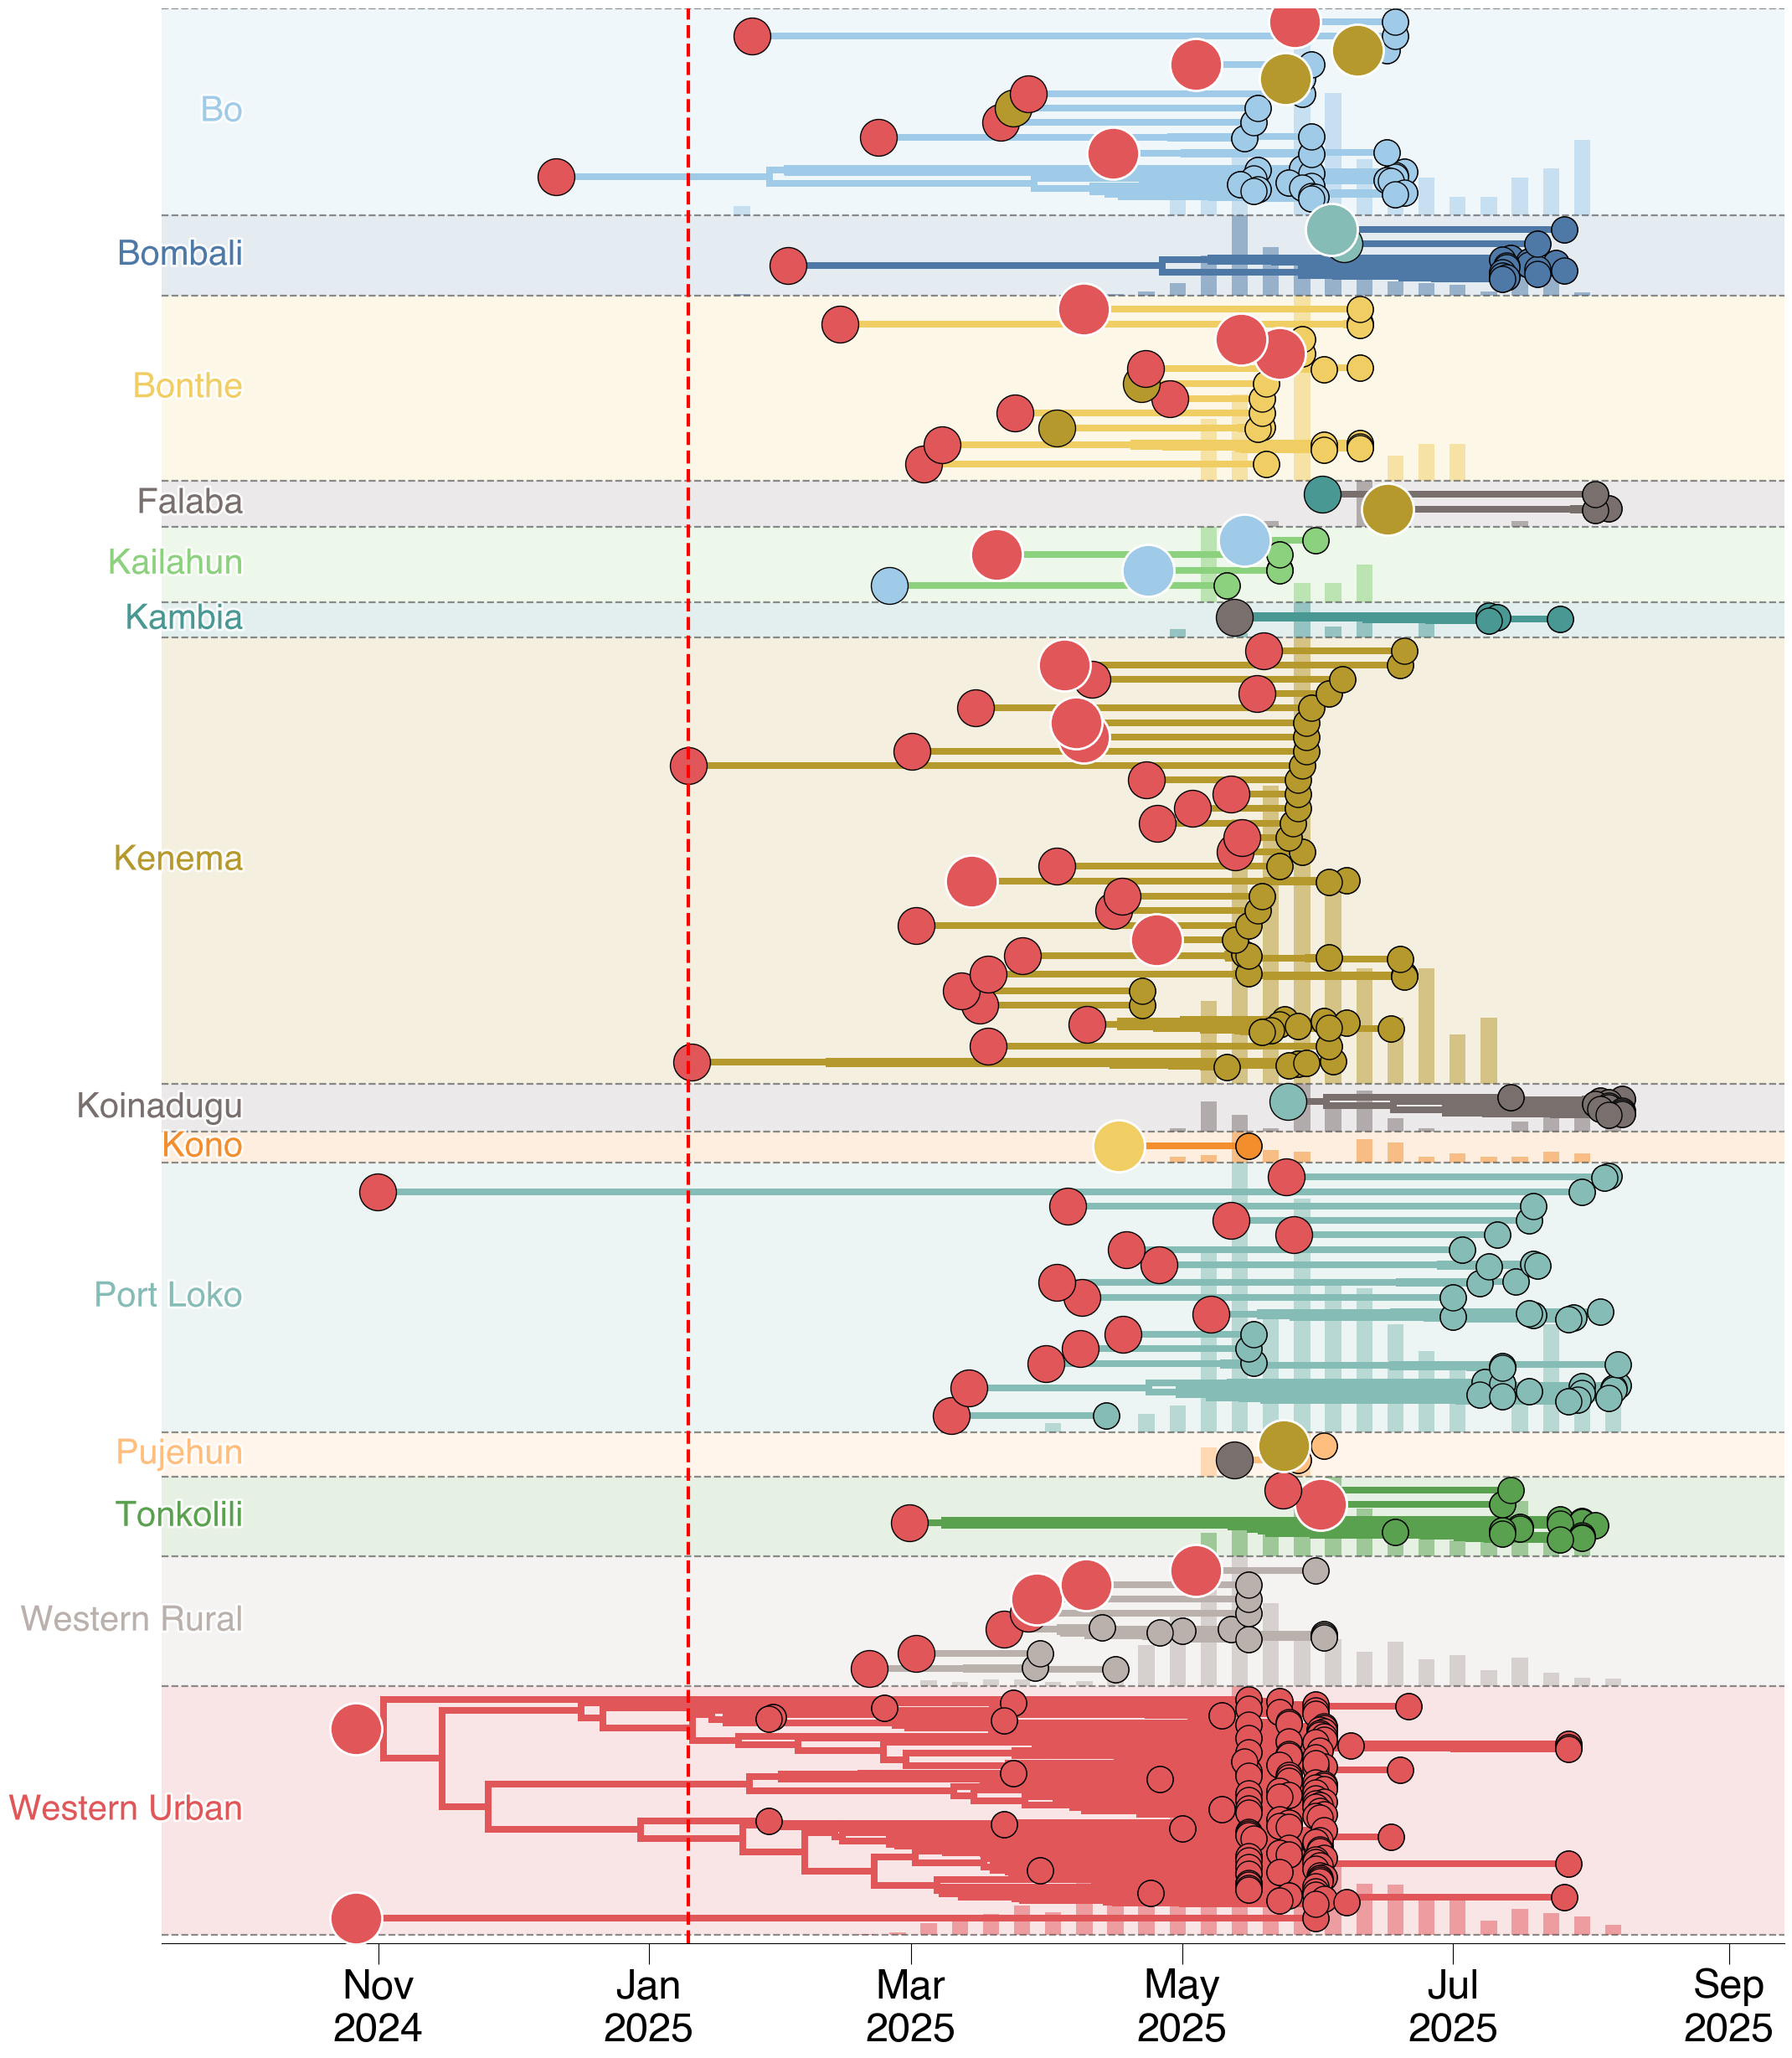

In [43]:
subtype_trees = enumerate_subtrees(tree)
SLE_exploded_tree(
    subtype_trees,
    "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/exploded_tree_district_colors.eps",
    25, 30, dpi=300
)

In [44]:
def decimal_to_days(decimal_value):
    days = int(decimal_value * 365)
    return days
def decimal_to_days(years_float): return float(years_float) * 365.25
def convertDate(date_str, in_fmt, out_fmt):
    return dt.datetime.strptime(date_str, in_fmt).strftime(out_fmt)


In [45]:
def scatterplot_persistence(
    subtype_trees2,
    filename,
    width=12,
    height=12,
    division_level="location",
    location_map=None,
    colors=None,
    division_order=None,
    key_order=None,
    zone_names=None
):
    if colors is None:        colors = globals().get("colors", {})
    if division_order is None: division_order = globals().get("division_order", list(colors.keys()))
    if zone_names is None:    zone_names = globals().get("zone_names", {k:k for k in division_order})

    raw_cases = pd.read_csv(
        "/Volumes/aine_store/SLE+IPD+KGH+CPHRL+2025-08-22/335+SKD+SLE+edited+DTA+Districts+SLE/sle_cases_long.csv",
        sep=","
    )

    if location_map is not None:
        raw_cases["location"] = raw_cases["location"].map(location_map).fillna(raw_cases["location"])

    raw_cases["date"] = pd.to_datetime(raw_cases["date"], errors="coerce")
    raw_cases = raw_cases.dropna(subset=["date", "location"])

    value_cols = raw_cases.select_dtypes(include="number").columns.tolist()
    weekly_data = (
        raw_cases
        .set_index("date")
        .groupby("location")[value_cols]
        .resample("W-Wed")
        .sum()
        .reset_index()
        .sort_values(["location","date"])
    )
    weekly_data["d_date"] = weekly_data["date"].astype(str).apply(lambda x: bt.decimalDate(x))

    if isinstance(key_order, dict) and key_order:
        missing = [k for k in subtype_trees2.keys() if k not in key_order]
        if missing:
            base = (max(key_order.values()) if len(key_order) else -1) + 1
            key_order = {**key_order, **{k: base+i for i, k in enumerate(sorted(missing))}}
    else:
        key_order = {k:i for i, k in enumerate(sorted(subtype_trees2.keys()))}

    mpl.rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex=False)
    mpl.rcParams.update({'font.size': 22})
    fig, ax1 = plt.subplots(figsize=(width, height), facecolor='w')

    traitName   = "location"
    cumulative_y = 0
    per_list     = []
    heights      = {division: [] for division in division_order} if division_order else {}

    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x: (key_order.get(x, 10**9), x))):
        starting_y = cumulative_y
        cumulative_y += 10

        for origin, loc_tree in subtype_trees2[i]:
            root   = loc_tree.root
            parent = getattr(root, "parent", None)

            # Posterior on parent if available, else root, else 1.0
            parent_traits = getattr(parent, "traits", {}) or {}
            root_traits   = getattr(root, "traits", {}) or {}
            post = parent_traits.get('posterior', root_traits.get('posterior', 1.0))

            if post >= 0.5:
                # number of leaves (avoid relying on .leaves on parent)
                w = sum(1 for k in loc_tree.Objects if getattr(k, "branchType", "") == "leaf")
                radius = np.sqrt(max(w,1)/np.pi) * 200.0

                # origin time = parent's absolute time if present, else root's
                originTime = getattr(parent, "absoluteTime", getattr(root, "absoluteTime"))

                # last tip time (max over all objects' absoluteTime)
                lastTip = max(getattr(k, "absoluteTime") for k in loc_tree.Objects)

                persist_days = decimal_to_days(lastTip - originTime)
                per_list.append([originTime, persist_days])

                ori_trait = root_traits.get(traitName, i)
                oriC = colors.get(ori_trait, "#999999")
                ax1.scatter(originTime, persist_days, s=radius, facecolor=oriC,
                            edgecolor='k', lw=2, zorder=200)

                cumulative_y += getattr(loc_tree, "ySpan", 0) + 8

        if division_order:
            ending_y = cumulative_y
            heights.setdefault(i, []).append((starting_y, ending_y, ending_y - starting_y))

    if not per_list:
        raise ValueError("No persistence points computed; check tree traits and filtering.")

    per_df = pd.DataFrame(per_list, columns=["date", "persistence"])
    r, p = pearsonr(per_df["date"], per_df["persistence"])
    ax1.text(.2, .75, f'r={r:.2f}, p={p:.2g}', transform=ax1.transAxes)

    sns.regplot(
        x="date", y="persistence", data=per_df, scatter=False, ax=ax1,
        color='steelblue', line_kws={'linestyle': '--', 'linewidth': 1},
        label=f'Pearson r={r:.2f}'
    )

    start_date = pd.Timestamp('2024-07-01')
    end_date   = pd.Timestamp('2025-08-01')
    tick_dates = pd.date_range(start_date, end_date, freq='2MS')
    xticks = [bt.decimalDate(d.strftime('%Y-%m-%d')) for d in tick_dates]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([
        d.strftime('%b\n%Y') if d.month in (1, 7) else d.strftime('%b')
        for d in tick_dates
    ])
    ax1.tick_params(axis='x', labelsize=25, size=0)

    shade_dates = pd.date_range(start_date, end_date + pd.DateOffset(months=2), freq='2MS')
    for i, d0 in enumerate(shade_dates[:-1]):
        d1 = shade_dates[i + 1]
        x0 = bt.decimalDate(d0.strftime('%Y-%m-%d'))
        x1 = bt.decimalDate(d1.strftime('%Y-%m-%d'))
        if i % 2 == 0:
            ax1.axvspan(x0, x1, facecolor='k', alpha=0.05, edgecolor='none', zorder=0)

    ax1.set_ylim(0, float(per_df["persistence"].max()) + 30.0)
    ax1.set_xlim(2024.75, 2025.6)
    ax1.set_ylabel("Persistence times (days)", fontsize=20, fontweight='bold')
    ax1.set_xlabel("", fontsize=25, fontweight='bold')

    plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()


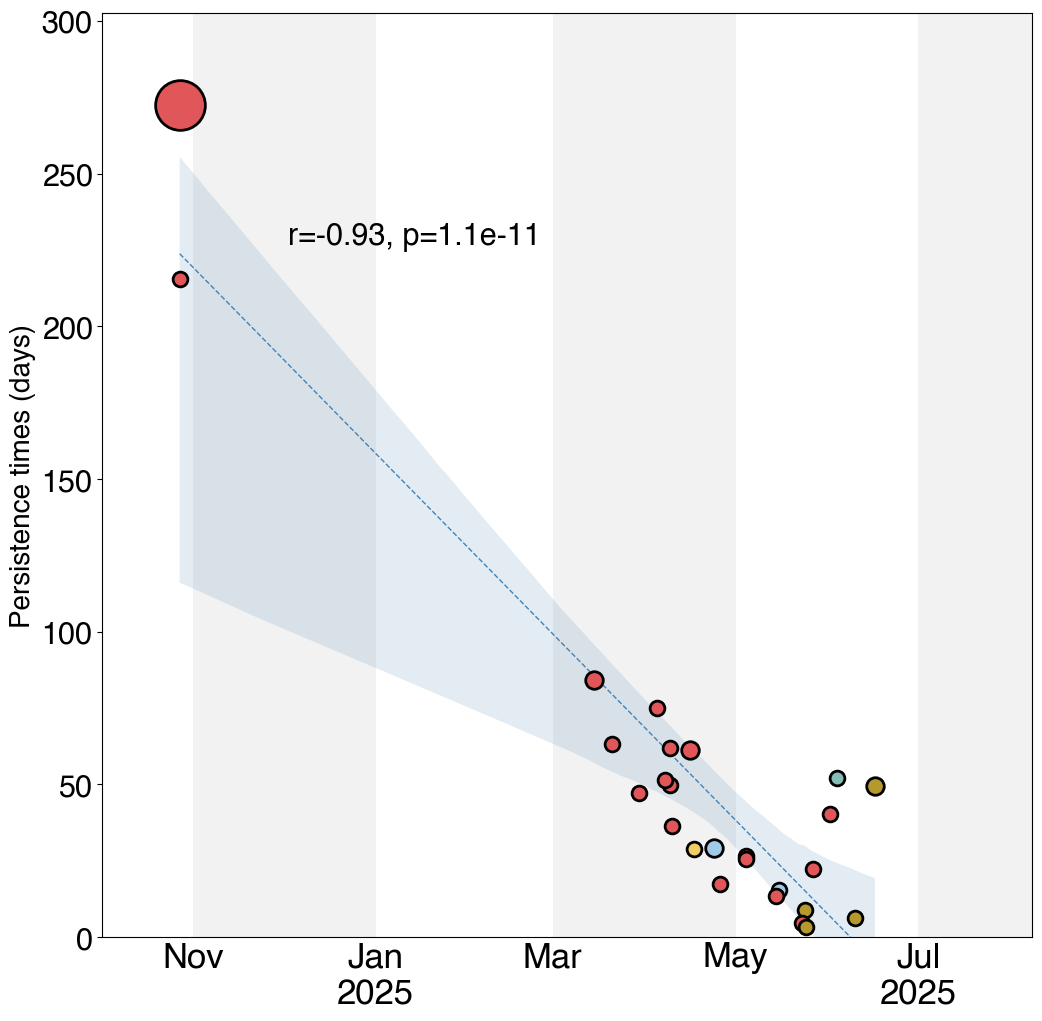

In [50]:
scatterplot_persistence(subtype_trees, "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/1newplot_acegid.png",12,12, "location")




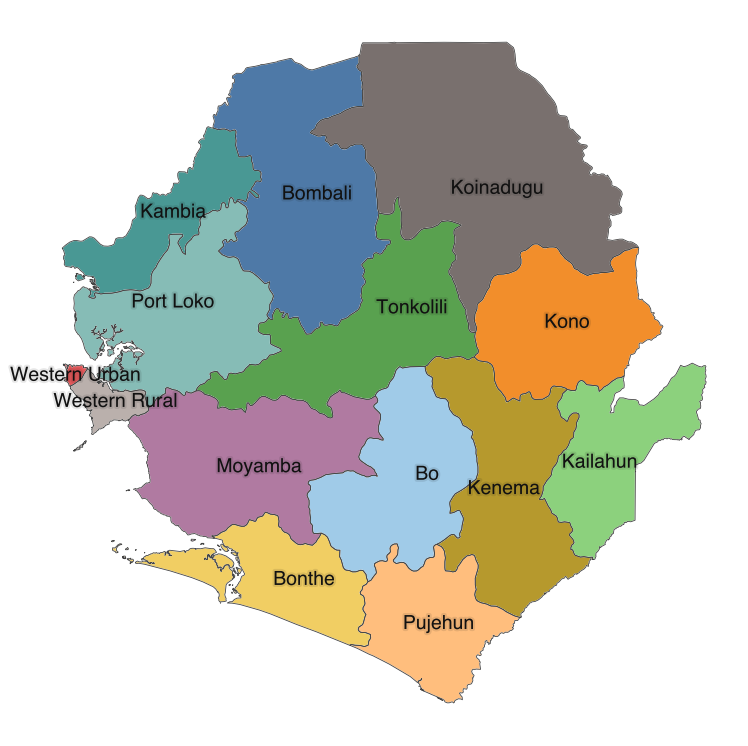

In [48]:


PRETTY = {
    "bo":"Bo","bonthe":"Bonthe","bombali":"Bombali","falaba":"Falaba",
    "kambia":"Kambia","koinadugu":"Koinadugu","kailahun":"Kailahun",
    "kenema":"Kenema","kono":"Kono","portloko":"Port Loko",
    "pujehun":"Pujehun","tonkolili":"Tonkolili",
    "westernurban":"Western Urban","westernrural":"Western Rural",
    "moyamba":"Moyamba","karene":"Karene"
}
COLOR = {
    "bo": "#A0CBE8", "bonthe": "#F1CE63", "bombali": "#4E79A7", "falaba": "#79706E",
    "kambia": "#499894", "koinadugu": "#79706E", "kailahun": "#8CD17D", "kenema": "#B6992D",
    "kono": "#F28E2B", "portloko": "#86BCB6", "pujehun": "#FFBE7D",
    "tonkolili": "#59A14F", "westernrural": "#BAB0AC", "westernurban": "#E15759",
    "moyamba": "#B07AA1", "karene": "#9C755F"
}

ALIASES = {
    "westernareaurban": "westernurban",
    "westernarearural": "westernrural",
    "westernareaurban": "westernurban",
    "westernarearural": "westernrural",
    "westernurban": "westernurban",
    "westernrural": "westernrural",
    "portloko": "portloko",
}

def to_slug(name: str) -> str:
    # normalize to [a-z0-9], remove spaces/hyphens/accents/etc.
    s = re.sub(r"[^a-z0-9]+", "", str(name).lower())
    return ALIASES.get(s, s)

def color_for(name: str) -> str:
    return COLOR.get(to_slug(name), "#DDDDDD")

def pretty_for(name: str) -> str:
    slug = to_slug(name)
    return PRETTY.get(slug, str(name).title())

GADM_JSON = "/Volumes/aine_store/gadm41_SLE_2.json"  # level-2 districts

gdf = gpd.read_file(GADM_JSON)

DIST_COL = next((c for c in ["NAME_2", "ADM2_EN", "ADM2_PCODE", "district", "District", "NAME_3"] if c in gdf.columns), None)
if DIST_COL is None:
    raise ValueError(f"Couldn't find a district name column in {GADM_JSON}. "
                     f"Available columns: {list(gdf.columns)}")

gdf["district_slug"] = gdf[DIST_COL].apply(to_slug)
gdf["fill"] = gdf[DIST_COL].apply(color_for)
gdf["label"] = gdf[DIST_COL].apply(pretty_for)

fig, ax = plt.subplots(figsize=(8, 10), facecolor="white")
gdf.plot(ax=ax, color=gdf["fill"], edgecolor="white", linewidth=0.8, zorder=2)
gdf.boundary.plot(ax=ax, color="#444444", linewidth=0.6, zorder=3)

reps = gdf.representative_point()
for (x, y, lab) in zip(reps.x, reps.y, gdf["label"]):
    ax.text(
        x, y, lab, ha="center", va="center", fontsize=14, color="#111111", zorder=4,
        path_effects=[path_effects.Stroke(linewidth=3, alpha=0.1),
                      path_effects.Normal()]
    )

ax.set_axis_off()
ax.set_title("", fontsize=25, fontweight="bold")

present = gdf.drop_duplicates("district_slug").sort_values("label")


plt.tight_layout()

#plt.savefig("/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/SLE_district_map.svg", dpi=300, bbox_inches="tight")
plt.savefig("/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Figure/SLE_district_map.svg", dpi=300, bbox_inches="tight")

plt.show()